In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
data = pd.read_csv("GOOGL_2006-01-01_to_2018-01-01.csv")

# Select features and target
features = data[['Open', 'High', 'Low']].values  # Input variables
target = data['Close'].values  # Output variable

# Normalize the data
scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

scaled_features = scaler_x.fit_transform(features)
scaled_target = scaler_y.fit_transform(target.reshape(-1, 1))


In [5]:
def create_lagged_data(features, target, time_steps=50):
    X, y = [], []
    for i in range(time_steps, len(features)):
        X.append(features[i-time_steps:i])  # Past `time_steps` for inputs
        y.append(target[i])  # Predict the target at `i`
    return np.array(X), np.array(y)

# Create lagged datasets
time_steps = 50
X, y = create_lagged_data(scaled_features, scaled_target, time_steps)

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("X_train shape:", X_train.shape)  # (samples, time_steps, features)
print("y_train shape:", y_train.shape)  # (samples, 1)


X_train shape: (2375, 50, 3)
y_train shape: (2375, 1)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

# Build the RNN model
model = Sequential()

# Add RNN layers
model.add(SimpleRNN(units=50, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(SimpleRNN(units=50, activation='tanh', return_sequences=False))
model.add(Dropout(0.2))

# Add output layer
model.add(Dense(units=1))  # Output a single value (e.g., Close price)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)


2024-11-29 18:56:21.370139: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732906581.400132  153799 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732906581.410400  153799 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-29 18:56:21.453309: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20


2024-11-29 18:56:23.479287: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/irene/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.1076 - val_loss: 0.0039
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0070 - val_loss: 0.0017
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0043 - val_loss: 0.0032
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0022 - val_loss: 6.8432e-04
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0017 - val_loss: 6.4547e-04
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0016 - val_loss: 4.1662e-04
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0014 - val_loss: 5.3032e-04
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0012 - val_loss: 5.5006e-04
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0012 - val_loss: 3.0584e-04
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/ste

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


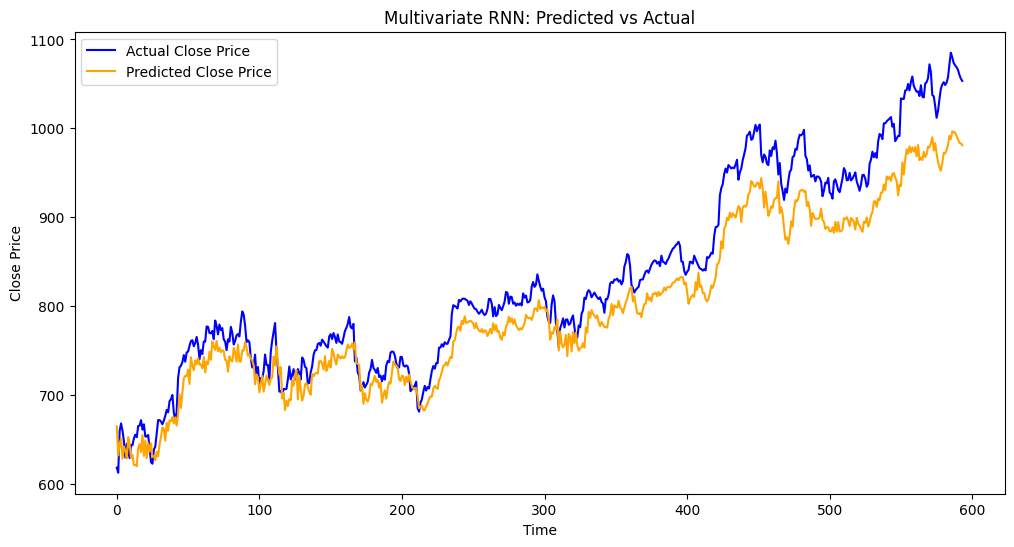

In [7]:
# Make predictions
y_pred = model.predict(X_test)

# Rescale predictions and test target
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test)

# Plot predictions vs actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Close Price", color="blue")
plt.plot(y_pred_rescaled, label="Predicted Close Price", color="orange")
plt.title("Multivariate RNN: Predicted vs Actual")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f"Root Mean Squared Error (RMSE): {rmse}")


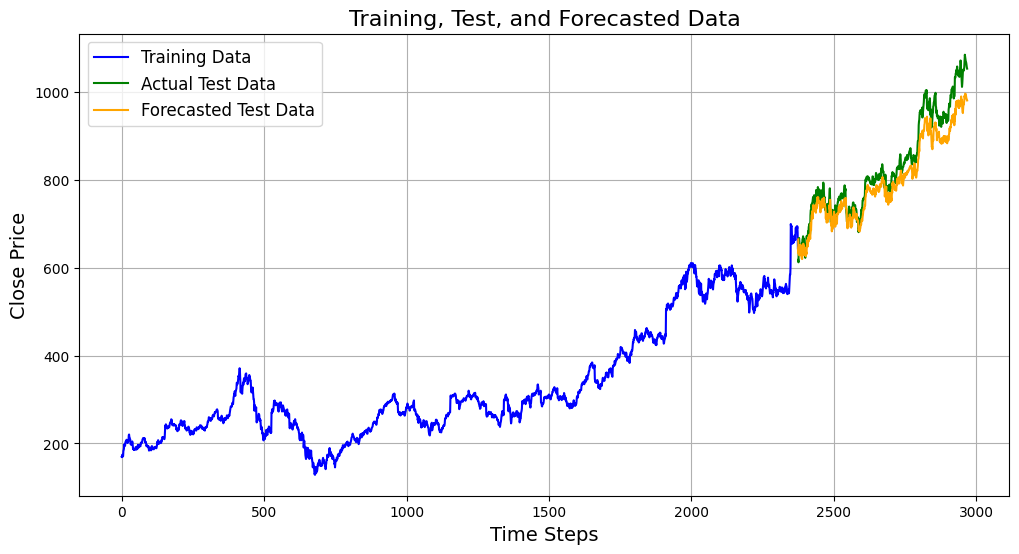

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming:
# y_train -> Training target values (scaled or original)
# y_test -> Test target values (scaled or original)
# y_pred_rescaled -> Predicted values for the test set (rescaled to the original scale)
# y_test_rescaled -> Test set target values rescaled to the original scale
# train_size -> The size of the training set
# target -> The original 'Close' column from the dataset

# Combine train and test data for plotting
all_data = np.concatenate((scaler_y.inverse_transform(y_train), y_test_rescaled))

# Create time indices for plotting
train_indices = range(train_size)  # Indices for training data
test_indices = range(train_size, train_size + len(y_test_rescaled))  # Indices for test data

# Plotting
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(train_indices, scaler_y.inverse_transform(y_train), label='Training Data', color='blue')

# Plot actual test data
plt.plot(test_indices, y_test_rescaled, label='Actual Test Data', color='green')

# Plot predicted test data (forecasted values)
forecast_start_index = train_size  # Predictions start after training data ends
plt.plot(test_indices, y_pred_rescaled, label='Forecasted Test Data', color='orange')

# Add labels, legend, and grid
plt.title("Training, Test, and Forecasted Data", fontsize=16)
plt.xlabel("Time Steps", fontsize=14)
plt.ylabel("Close Price", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Save the plot
plt.savefig("train_test_forecast.png")

# Show the plot
plt.show()
